In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import keras

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt


## Upload Dataset

In [31]:
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
#Variable defining
SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)

data_dir = '../input/brain-tumor-mri-dataset/'
train_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Testing')

## Define Categories

In [32]:
CATEGORIES = ['glioma', 'meningioma', 'notumor', 'pituitary']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

## Training sample

In [33]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

glioma 1321 images
meningioma 1339 images
notumor 1595 images
pituitary 1457 images


In [34]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size) ## https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img
    img = image.img_to_array(img)
    return img


In [35]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['Training/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(5712, 3)

In [36]:
train['category_id'].value_counts()

2    1595
3    1457
1    1339
0    1321
Name: category_id, dtype: int64

In [37]:
train.head(2)

,file,category_id,category
0,Training/glioma/Tr-gl_0954.jpg,0,glioma
1,Training/glioma/Tr-gl_0959.jpg,0,glioma


## Generating vector for training samples taking equal number of images from each category

In [38]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.shape

(800, 3)

In [39]:
train.head()

,file,category_id,category
0,Training/notumor/Tr-no_0369.jpg,2,notumor
1,Training/notumor/Tr-no_1041.jpg,2,notumor
2,Training/meningioma/Tr-me_1134.jpg,1,meningioma
3,Training/meningioma/Tr-me_0360.jpg,1,meningioma
4,Training/meningioma/Tr-me_0961.jpg,1,meningioma


## Understanding test-set

In [40]:
test = []
for file in os.listdir(test_dir):
    test.append(['testDatasets/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.shape

(4, 2)

In [41]:
test.head(2)

,filepath,file
0,testDatasets/pituitary,pituitary
1,testDatasets/notumor,notumor


## Generating example images

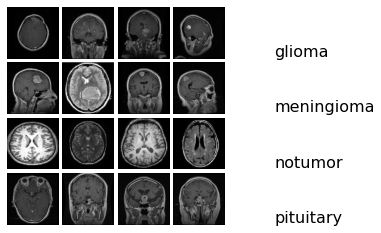

In [53]:

fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0    
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1
        
plt.show();

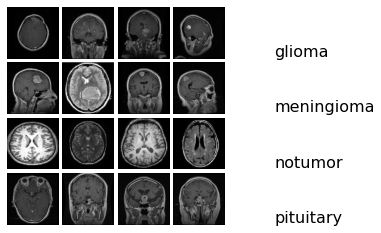

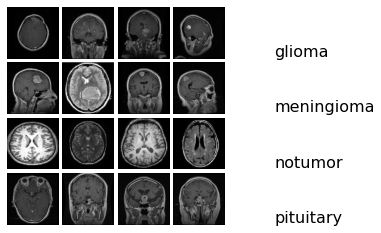

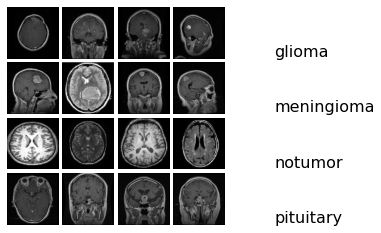

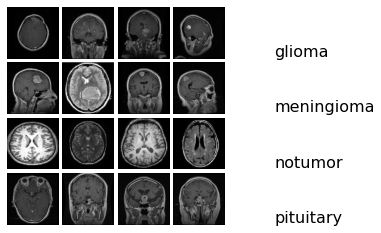

In [54]:
## Repeated 4 times
for j in range (4):

    fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
    grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
    i = 0
    for category_id, category in enumerate(CATEGORIES):
        for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
            ax = grid[i]
            img = read_img(filepath, (WIDTH, HEIGHT))
            ax.imshow(img / 255.)
            ax.axis('off')
            if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
                ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
            i += 1
    plt.show();
j+=1

In [ ]:
np.random.seed(seed=SEED)

## VGG-19 model layers identification

In [ ]:
def setTrainableLayersVGG(vgg_model):
    set_trainable = False
    for layer in vgg_model.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
            
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return vgg_model

In [ ]:
vgg = VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model = setTrainableLayersVGG(vgg_model)
# vgg_model.trainable = False
# for layer in vgg_model.layers:
#     layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

## ResNet-50 model identification

In [ ]:
def setTrainableLayersResNet(resnet_model):
    set_trainable = False
    for layer in resnet_model.layers:
        if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
            set_trainable = True
            
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    return resnet_model

## Called model

In [ ]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet_model = Model(resnet.input, output)

setTrainableLayersResNet(resnet_model)
# resnet_model.trainable = False
# for layer in resnet_model.layers:
#     layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

## History

In [ ]:
def printHistory(history, title, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [ ]:
#create model from scratch
def createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs):
    print("Create Model")

    tranfer_model = 0 # just define
    
    if pretrainedModel == "ResNet-50":
        tranfer_model = ResNet50(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False)
        if fineTune == True:
            tranfer_model = setTrainableLayersResNet(tranfer_model)
        else:
            for layer in tranfer_model.layers:
                tranfer_model.trainable = False  # freeze feature extracting layers
    elif pretrainedModel == "VGG-19":
        tranfer_model = VGG19(weights='imagenet', input_shape=INPUT_SHAPE, include_top=False)
        
        if fineTune == True:
            tranfer_model = setTrainableLayersVGG(tranfer_model)
        else:
            for layer in tranfer_model.layers:
                layer.trainable = False  # freeze feature extracting layers

    output = tranfer_model.layers[-1].output
    output = keras.layers.Flatten()(output)
    trans_model = Model(tranfer_model.input, output)
    
    model = Sequential()
    model.add(trans_model)
    
    for i in range(0,number_of_hidden_layers):
        model.add(Dense(512))
        model.add(Activation(activation))
        model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax'))

    if optimizer == 'SGD':
        opt = SGD(learning_rate =learning_rate, decay=learning_rate / epochs)
    elif optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate, decay=learning_rate / epochs)

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
#callbacks for keras modal
def get_callbacks(patience):
    print("Get Callbacks")

    lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=1e-5, patience=patience, verbose=1)
    #msave = ModelCheckpoint(filepath, save_best_only=True)
    return [lr_reduce, EarlyStopping()]

In [ ]:
def trainModelDF(images, pretrainedModel, fineTune, epochs, batch_size, learning_rate, cross_validation_folds, activation, number_of_hidden_layers, optimizer):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255)
    
    datagen_valid = ImageDataGenerator(rescale=1./255)
        
    print("Cross validation")
    kfold = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True)
    cvscores = []
    iteration = 1
    
    t = images.category_id
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):

        print("======================================")
        print("Iteration = ", iteration)

        iteration = iteration + 1

        train = images.loc[train_index]
        test = images.loc[test_index]

        print("======================================")
        
        model = createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs)

        print("======================================")
    
       
        train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="../input/brain-tumor-mri-dataset/",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));
        valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                                  directory="../input/brain-tumor-mri-dataset/",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=batch_size,
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
        
       #Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit(train_generator,\
                            validation_data = valid_generator, \
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            validation_steps=STEP_SIZE_VALID, \
                            epochs=epochs, \
                            verbose=1)#, \
#                             callbacks = get_callbacks(patience=2))
        
        scores = model.evaluate(valid_generator, steps=STEP_SIZE_VALID)
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
        printHistory(history, pretrainedModel, epochs)

    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))
    return accuracy, std        

## VGG-19 as a feature extractor

In [ ]:
trainModelDF(
    train,
    pretrainedModel = "VGG-19", #ResNet-50
    fineTune = False,
    batch_size =32,
    cross_validation_folds = 5,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 2,
    optimizer = 'Adam',
    epochs = 5
)

## VGG-19 tuning last 2 layers as well

In [ ]:
# trainModelDF(
#     train,
#     pretrainedModel = "VGG-19", #ResNet-50
#     fineTune = True,
#     batch_size =32,
#     cross_validation_folds = 5,
#     learning_rate = 0.001,
#     activation = 'relu',
#     number_of_hidden_layers = 2,
#     optimizer = 'Adam',
#     epochs = 24
# )

## ResNet-50 as a feature extractor

In [ ]:
trainModelDF(
    train,
    pretrainedModel = "ResNet-50", #ResNet-50
    fineTune = False,
    batch_size =4,
    cross_validation_folds = 5,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 1,
    optimizer = 'Adam',
    epochs = 20
)

## ResNet-50 with fine tuning last 2 layers

In [ ]:
# trainModelDF(
#     train,
#     pretrainedModel = "ResNet-50", #ResNet-50
#     fineTune = True,
#     batch_size = 4,
#     cross_validation_folds = 5,
#     learning_rate = 0.001,
#     activation = 'relu',
#     number_of_hidden_layers = 1,
#     optimizer = 'Adam',
#     epochs = 10
# )

In [ ]:
def trainFinalModel(images, pretrainedModel, fineTune, epochs, batch_size, learning_rate, activation, number_of_hidden_layers, optimizer):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255)
    
    print("======================================")    
    model = createModel(pretrainedModel, fineTune, number_of_hidden_layers, activation, optimizer, learning_rate, epochs)
    print("======================================")
    
    train_generator = datagen_train.flow_from_dataframe(dataframe=images,
                                                        directory="../input/brain-tumor-mri-dataset/",
                                                        x_col="file",
                                                        y_col="category",
                                                        batch_size=batch_size,
                                                        seed=SEED,
                                                        shuffle=True,
                                                        class_mode="categorical",
                                                        target_size=(HEIGHT, WIDTH));
        
    print (train_generator.class_indices)
    
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    #Trains the model on data generated batch-by-batch by a Python generator
    model.fit(train_generator,\
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            epochs=epochs, \
                            verbose=1)#, \
#                             callbacks = get_callbacks(patience=2))
        
    model.save("/kaggle/working/best_model")
    
    return train_generator.class_indices

In [ ]:
#predict values 
def predict_createSubmission(class_indices):
    print("Predicting......")
    
    datagen_test = ImageDataGenerator(rescale=1./255)
    
    test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                        directory="../input/brain-tumor-mri-dataset/",
                                                        x_col="file",
                                                        y_col=None,
                                                        batch_size=1,
                                                        seed=SEED,
                                                        shuffle=False,
                                                        class_mode=None,
                                                        target_size=(HEIGHT, WIDTH));
        
    model = load_model('/kaggle/working/best_model')
    filenames = test_generator.filenames
    nb_samples = len(filenames)

    predictions = model.predict(test_generator,steps = nb_samples) # return prob of each class per image (softmax)
    
    predicted_class_indices=np.argmax(predictions,axis=1)
    
    labels = dict((v,k) for k,v in class_indices.items())
    predicted_labels = [labels[k] for k in predicted_class_indices]
    
    results=pd.DataFrame({"file":filenames,
                          "species":predicted_labels})

    print (results)
    
    results.to_csv("submission.csv",index=False)

    print("Prediction Completed")

In [ ]:
class_indices = trainFinalModel(
    train,
    pretrainedModel = "VGG-19", #ResNet-50
    fineTune = False,
    batch_size = 32,
    learning_rate = 0.001,
    activation = 'relu',
    number_of_hidden_layers = 2,
    optimizer = 'Adam',
    epochs = 20
)